In [177]:
import requests
import zipfile
import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance,PartialDependenceDisplay



In [178]:
URL="https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
response = requests.get(URL)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    zip_ref = z.extractall(r"./Datasets/")


In [179]:
red_df = pd.read_csv("./Datasets/winequality-red.csv", sep=';')
red_df['color'] = 'red'
white_df = pd.read_csv("./Datasets/winequality-white.csv", sep=';')
white_df['color'] = 'white'
df= pd.concat([red_df, white_df], ignore_index=True)

In [180]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

In [181]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [182]:
df.shape

(6497, 13)

In [183]:
df.describe().T

count        mean        std      min       25%  \
fixed acidity         6497.0    7.215307   1.296434  3.80000   6.40000   
volatile acidity      6497.0    0.339666   0.164636  0.08000   0.23000   
citric acid           6497.0    0.318633   0.145318  0.00000   0.25000   
residual sugar        6497.0    5.443235   4.757804  0.60000   1.80000   
chlorides             6497.0    0.056034   0.035034  0.00900   0.03800   
free sulfur dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total sulfur dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
pH                    6497.0    3.218501   0.160787  2.72000   3.11000   
sulphates             6497.0    0.531268   0.148806  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%        75%        max  
fixed acidity           7.00000    7.70000   15.90000  
volatile acidity        0.29000    0.40000    1.58000  
citric acid             0.31000    0.39000    1.66000  
residual sugar          3.00000    8.10000   65.80000  
chlorides               0.04700    0.06500    0.61100  
free sulfur dioxide    29.00000   41.00000  289.00000  
total sulfur dioxide  118.00000  156.00000  440.00000  
density                 0.99489    0.99699    1.03898  
pH                      3.21000    3.32000    4.01000  
sulphates               0.51000    0.60000    2.00000  
alcohol                10.30000   11.30000   14.90000  
quality                 6.00000    6.00000    9.00000

In [184]:
df.drop(columns='quality', inplace=True)

In [185]:
df.dtypes.value_counts()

float64    11
object      1
Name: count, dtype: int64

In [186]:
df["color"] = df["color"].map({"red": 1, "white": 0}).astype(int)  # Binary encoding

df.corrwith(df['color']).sort_values(ascending=False)

color                   1.000000
volatile acidity        0.653036
chlorides               0.512678
sulphates               0.487218
fixed acidity           0.486740
density                 0.390645
pH                      0.329129
alcohol                -0.032970
citric acid            -0.187397
residual sugar         -0.348821
free sulfur dioxide    -0.471644
total sulfur dioxide   -0.700357
dtype: float64

- Red wines usually have more acidity, chlorides and sulphates.
- White wines tend to have more residual sugar and sulfur dioxide.


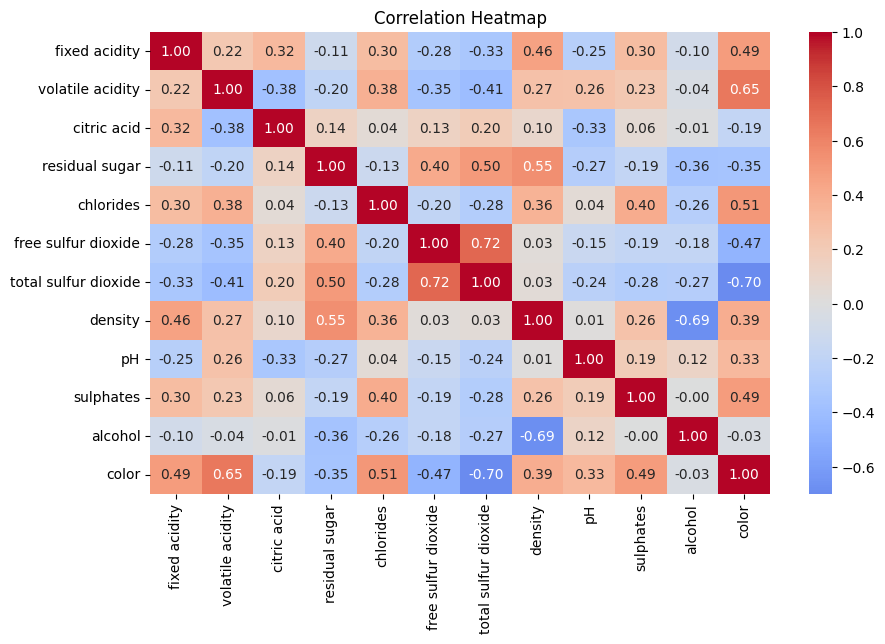

In [187]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

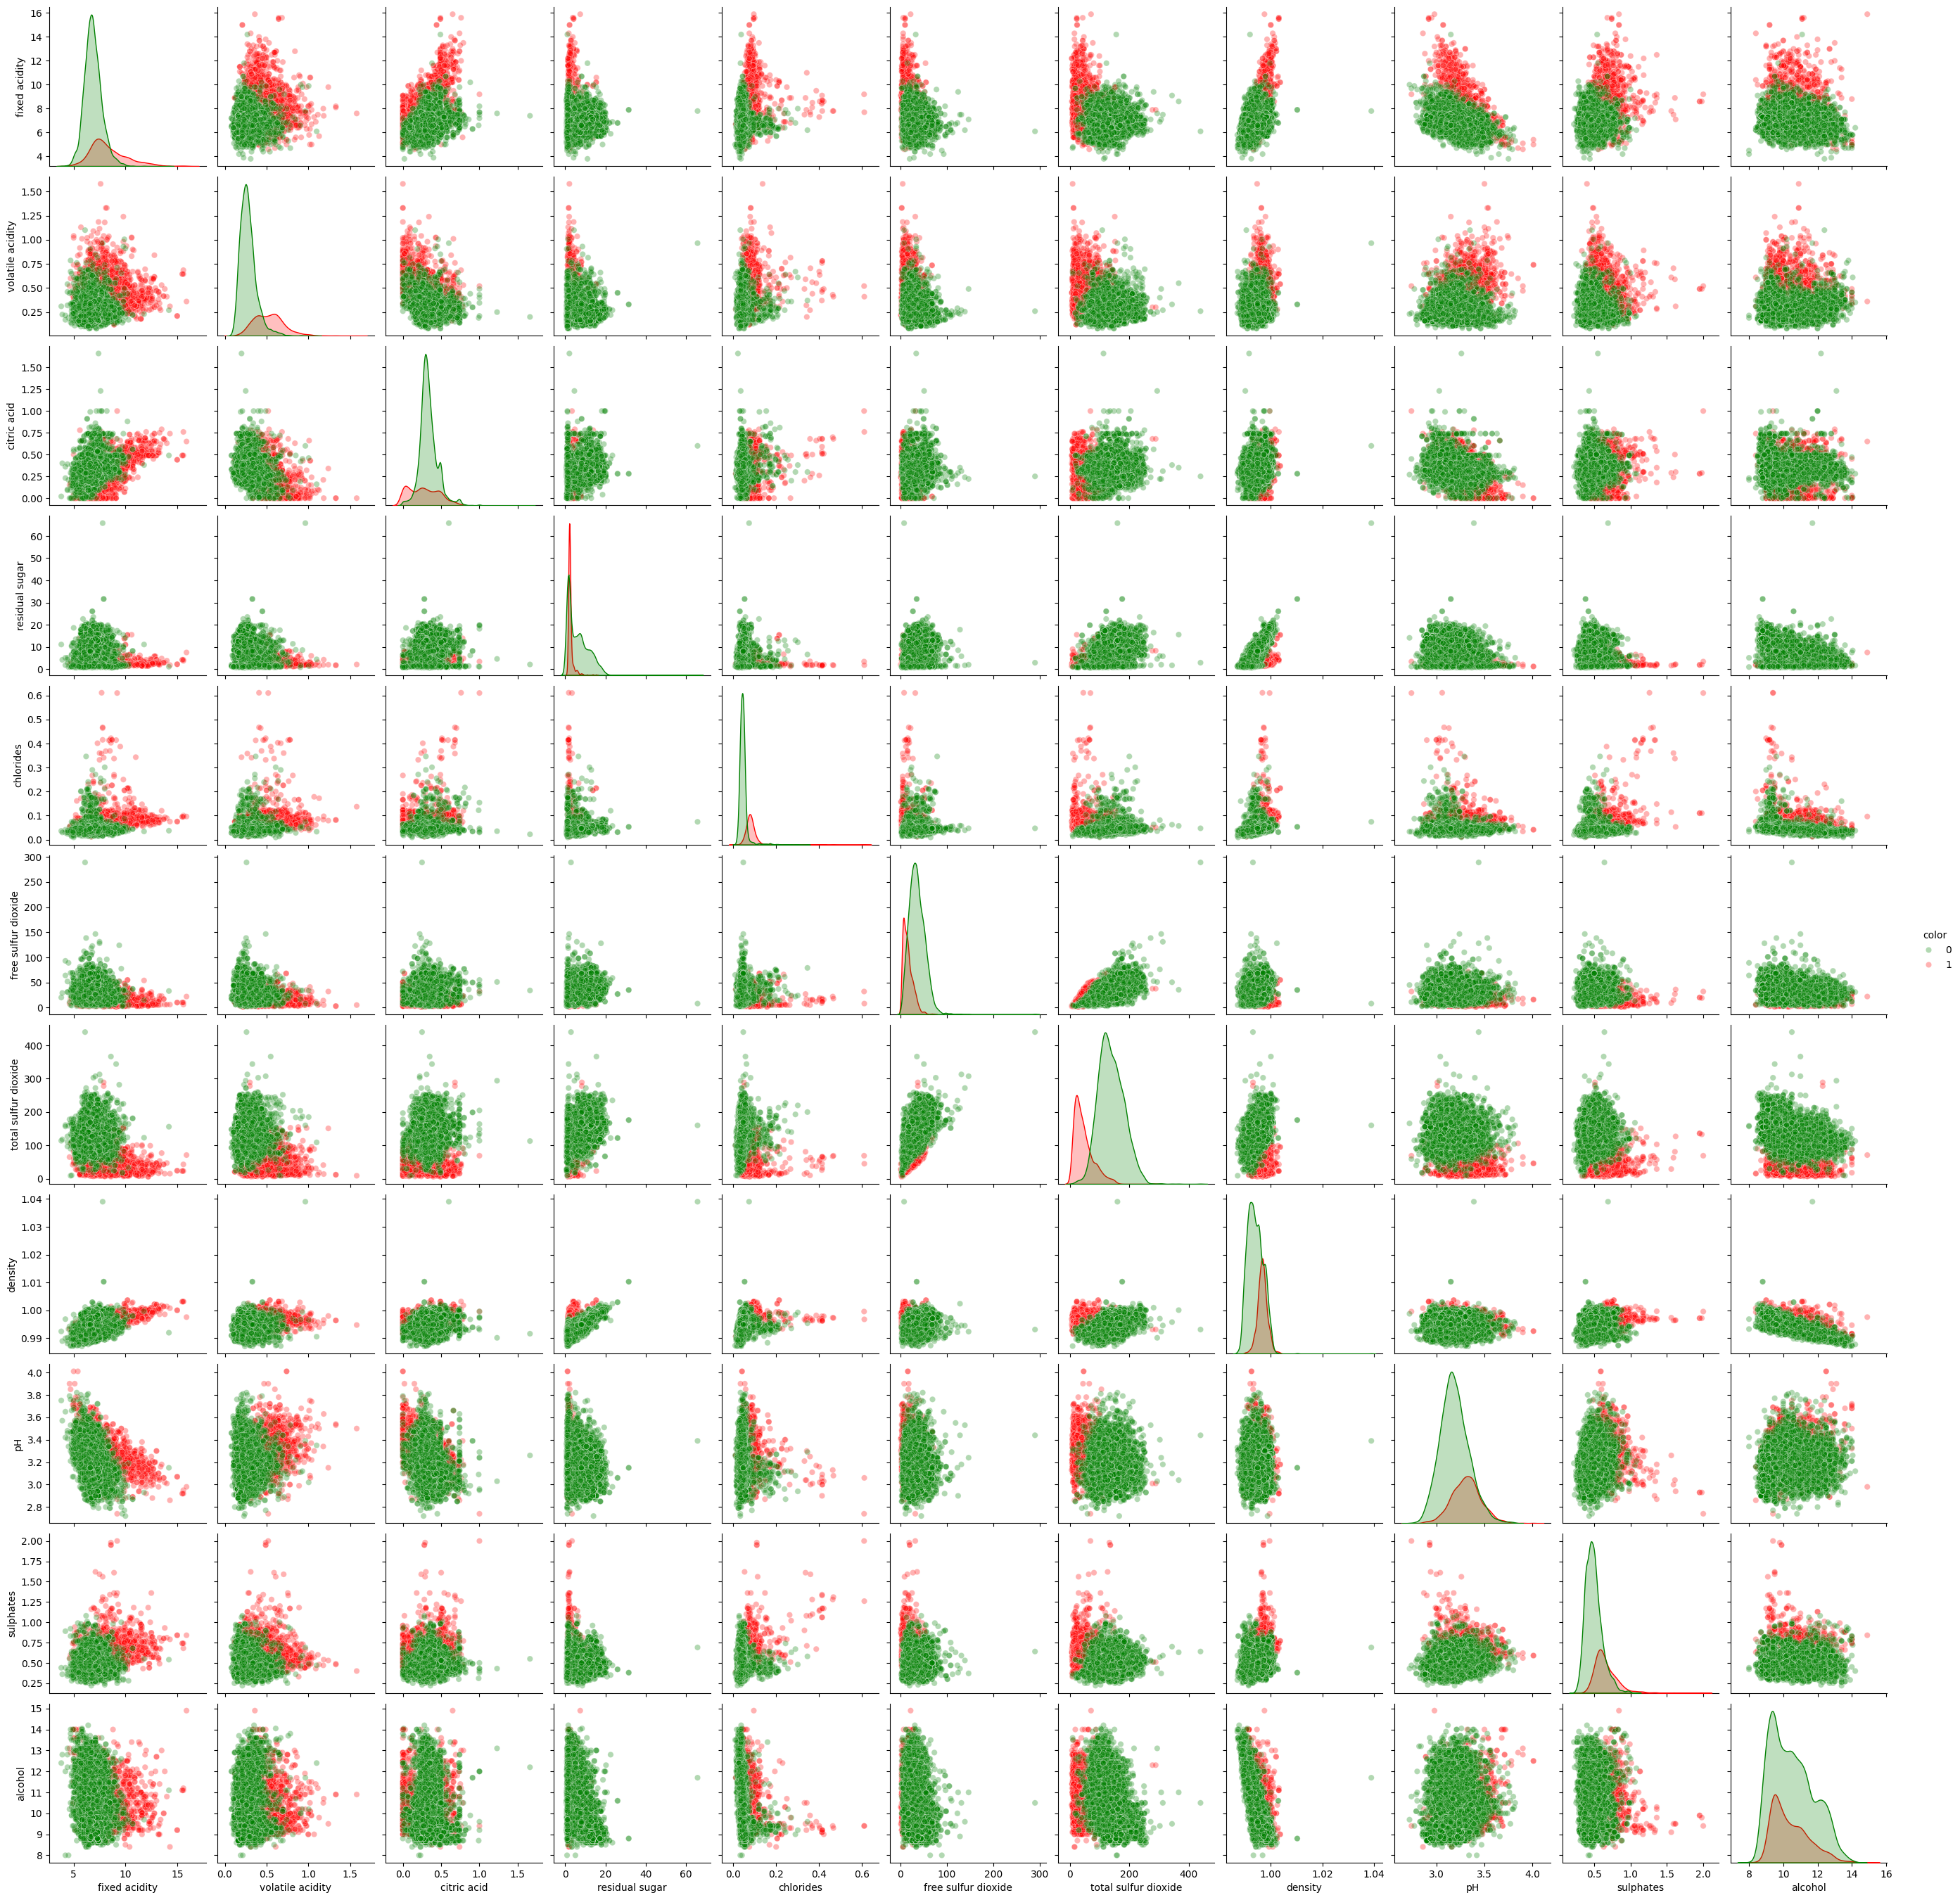

In [188]:
color={1: 'r', 0: 'g'}
sns.pairplot(df, diag_kind='kde', hue='color',palette=color, plot_kws={'alpha':0.3})

In [189]:
X= df.drop(columns=['color'])
y= df['color']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
param_grid = {
    "Logistic Regression": {"classifier__C": [0.1, 1, 10]},
    "Random Forest": {"classifier__n_estimators": [50, 100, 200], "classifier__max_depth": [None, 10, 20]},
    "Gradient Boosting": {"classifier__learning_rate": [0.01, 0.1, 0.5], "classifier__n_estimators": [50, 100]},
    "Support Vector Machine": {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]},
    "K-Nearest Neighbors": {"classifier__n_neighbors": [3, 5, 7]},
    "Naive Bayes": {},
    "Decision Tree": {"classifier__max_depth": [None, 5, 10], "classifier__min_samples_split": [2, 5]}
}


In [191]:
best_models = {}

for name, pipeline in pipelines.items():
    if name in param_grid and param_grid[name]:  # Skip models without hyperparameters
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        pipeline.fit(X_train, y_train)
        best_models[name] = pipeline

Best parameters for Logistic Regression: {'classifier__C': 10}
Best parameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 5}


In [192]:
# Create a list to store model scores
model_scores = []

# Loop through models, compute scores, and store results
for name, model in best_models.items():
    score = model.score(X_test, y_test)
    model_scores.append((name, score))  # Store model name and accuracy
    print(f"{name}: Tuned Accuracy = {score:.4f}")

# Convert to DataFrame and sort
top_models_df = pd.DataFrame(model_scores, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False).head(3).reset_index(drop=True)

Logistic Regression: Tuned Accuracy = 0.9892
Decision Tree: Tuned Accuracy = 0.9831
Random Forest: Tuned Accuracy = 0.9938
Gradient Boosting: Tuned Accuracy = 0.9931
Support Vector Machine: Tuned Accuracy = 0.9938
K-Nearest Neighbors: Tuned Accuracy = 0.9900
Naive Bayes: Tuned Accuracy = 0.9715


In [193]:
top_models_df

Model  Accuracy
0           Random Forest  0.993846
1  Support Vector Machine  0.993846
2       Gradient Boosting  0.993077

In [194]:
y_probabilities = {}  # Store probabilities for models that support it
roc_data = {}  # Store FPR, TPR, AUC data

for name in top_models_df["Model"]:
    model = best_models[name]  # Retrieve trained model
    
    if hasattr(model, "predict_proba"):  # Check if model supports probability prediction
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probability of positive class
    elif hasattr(model, "decision_function"):  # Use decision function for SVM
        y_prob = model.decision_function(X_test)
    else:  # If neither is available, use raw predictions
        y_prob = model.predict(X_test)  # Convert to probabilities if needed (not ideal)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    # Store results
    y_probabilities[name] = y_prob
    roc_data[name] = (fpr, tpr, auc_score)

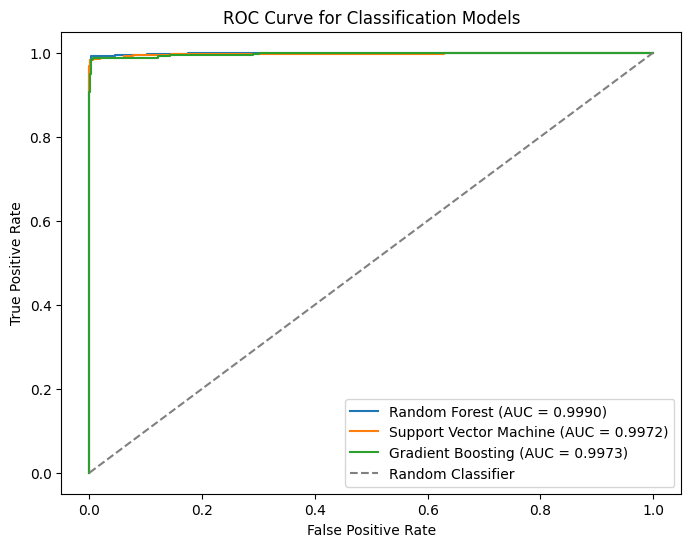

In [195]:
plt.figure(figsize=(8, 6))

# Plot ROC curves for each model
for name, (fpr, tpr, auc_score) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

# Add diagonal line for random classifier
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Classification Models")
plt.legend(loc="lower right")

# Show plot
plt.show()

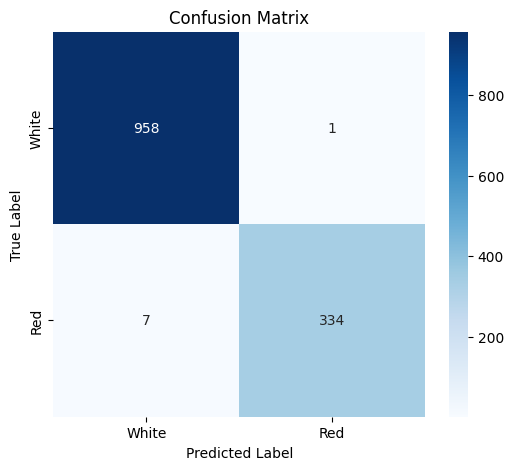

In [196]:
y_pred = best_models["Random Forest"].predict(X_test)  # Replace with the desired model

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["White", "Red"], yticklabels=["White", "Red"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()


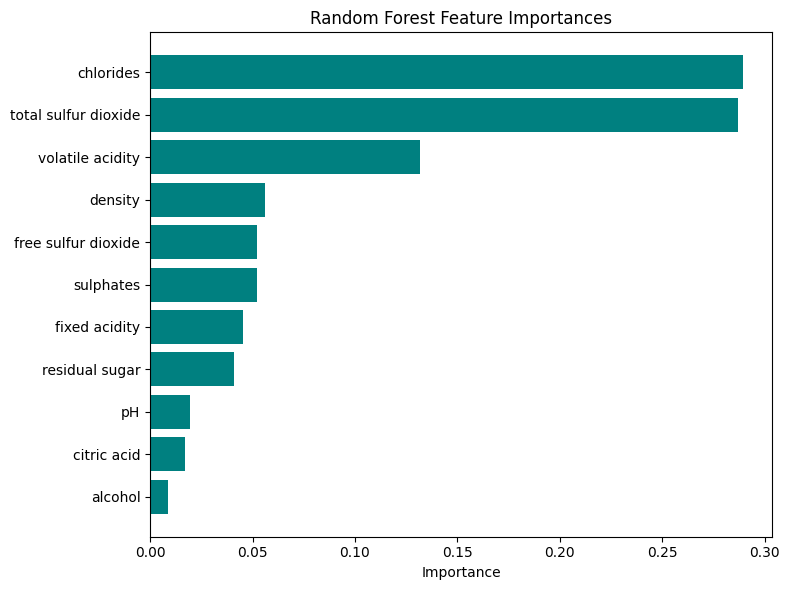

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume you already have a trained Random Forest pipeline
rf_model = best_models["Random Forest"]

# Extract the classifier from the pipeline
classifier = rf_model.named_steps["classifier"]

# Get feature importances
importances = classifier.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="teal")
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


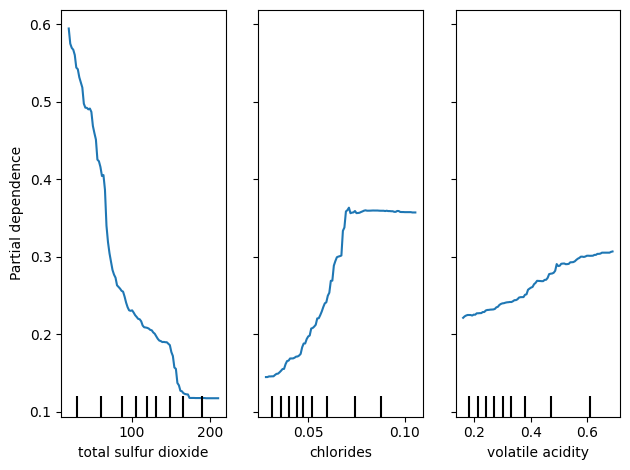

In [209]:
PartialDependenceDisplay.from_estimator(rf_model, X_test, features=["total sulfur dioxide", "chlorides","volatile acidity"], kind="average")
plt.tight_layout()
plt.show()


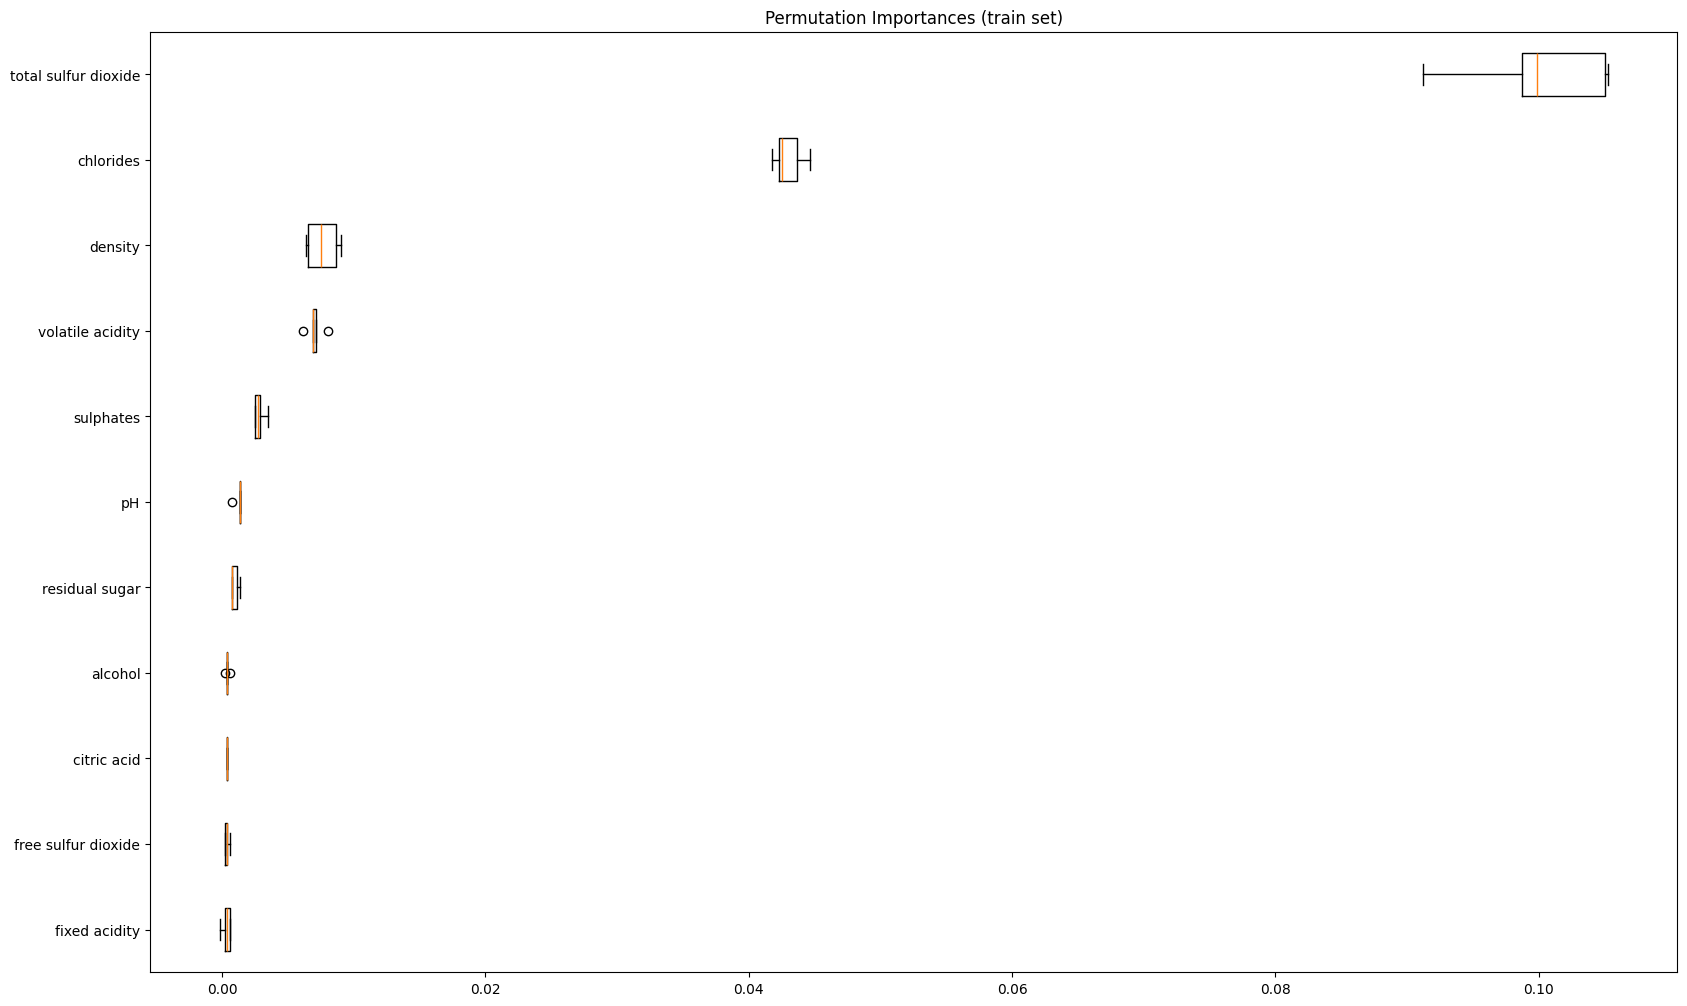

In [199]:
feature_importances = permutation_importance(estimator=rf_model, X = X_train, y = y_train, n_repeats=5,
                                random_state=123, n_jobs=2)

sorted_idx = feature_importances.importances_mean.argsort()
    # Visualize the feature importances using boxplot
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(10)
fig.tight_layout()
ax.boxplot(feature_importances.importances[sorted_idx].T,vert=False, tick_labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
plt.show()

In [200]:
# normalize X_test
min_max_scaler = StandardScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)

In [201]:
lm_surrogate = LogisticRegression(max_iter=1000, 
                                  random_state=42, penalty='l1', solver='liblinear')
lm_surrogate.fit(X_test_minmax, y_pred)

LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [202]:
y_surrogate = lm_surrogate.predict(X_test_minmax)

In [203]:
accuracy_score(y_pred, y_surrogate)

1.0

In [204]:
# Filter coefficients less than 0.01
coef_dict = {}
for coef, feat in zip(lm_surrogate.coef_[0, :], X_test.columns):
    if abs(coef) >= 0.01:
        coef_dict[feat] = coef
# Sort coefficients
coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
coef_dict

{'residual sugar': np.float64(-3.829228887202778),
 'total sulfur dioxide': np.float64(-2.9641772860608437),
 'citric acid': np.float64(-0.7445997169799365),
 'pH': np.float64(0.25378668150618344),
 'sulphates': np.float64(0.7566270437501118),
 'volatile acidity': np.float64(0.760666291211948),
 'chlorides': np.float64(0.9980829051361885),
 'alcohol': np.float64(1.4721855173219118),
 'density': np.float64(5.949602447609325)}

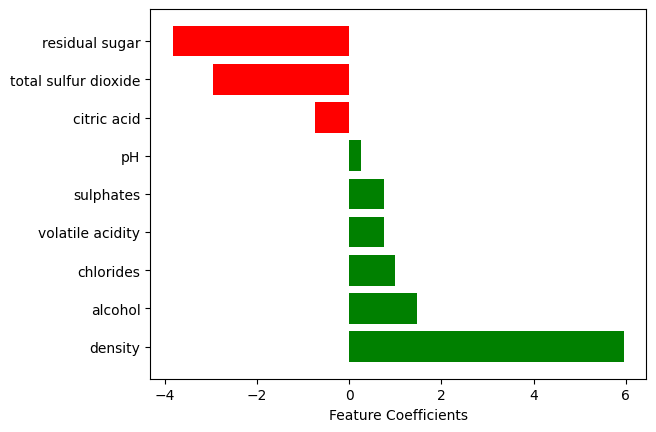

In [205]:
features = list(coef_dict.keys())
values = list(coef_dict.values())
y_pos = np.arange(len(features))
color_vals = []
for val in values:
    if val <= 0:
        color_vals.append('r')
    else:
        color_vals.append('g')
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, values, align='center', color=color_vals)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
# labels read top-to-bottom
ax.invert_yaxis()  
ax.set_xlabel('Feature Coefficients')
ax.set_title('')
plt.show()

In [210]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Step 1: Get predictions from the Random Forest
rf_predictions = best_models["Random Forest"].predict(X_train)

# Step 2: Train a Logistic Regression model using RF predictions as labels
surrogate = LogisticRegression()
surrogate.fit(X_train, rf_predictions)  # Surrogate learns from RF outputs

# Step 3: Evaluate fidelity (how well it mimics the RF)
pred_surrogate = surrogate.predict(X_train)
fidelity = accuracy_score(rf_predictions, pred_surrogate)

print(f"Surrogate model fidelity to Random Forest: {fidelity:.4f}")


Surrogate model fidelity to Random Forest: 0.9844


c:\Users\Ricardo Ferreira\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [207]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plot_tree(surrogate, feature_names=X_train.columns, class_names=["White", "Red"], filled=True)
plt.title("Surrogate Decision Tree (approximates Random Forest)")
plt.show()

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got LogisticRegression() instead.

<Figure size 1200x600 with 0 Axes>

In [211]:
coef_dict = {}
    # Filter coefficients less than 0.01
for coef, feat in zip(surrogate.coef_[0, :], X_test.columns):
    if abs(coef) >= 0.01:
        coef_dict[feat] = coef
    # Sort coefficients
coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

In [212]:
# Create DataFrame for plotting
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="coral")
plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length